
# PaySim 데이터셋 기반 RFM 분석 및 Fraud 탐지

## 1. RFM 분석 개요
RFM 분석은 고객 행동을 세 가지 지표로 요약하는 전통적인 방법입니다.

- **Recency (R)**: 최근 거래 시점 → 최근일수록 고객이 '활성' 상태일 확률이 높음
- **Frequency (F)**: 거래 빈도 → 자주 거래하는 고객일수록 충성도가 높거나, Fraud 시도 가능성도 존재
- **Monetary (M)**: 거래 금액 → 금액 규모가 클수록 기업 기여도가 크지만, 동시에 Fraud 타깃 가능성도 증가

RFM을 통해 고객을 세분화하면, **VIP 고객, 휴면 고객, 사기 위험군** 등을 구체적으로 나눌 수 있습니다.

## 2. PaySim 데이터셋 특성
- **출처**: Kaggle – Synthetic Financial Datasets For Fraud Detection (PaySim)
- **형태**: 약 11만 건의 금융 거래 시뮬레이션 데이터
- **컬럼 주요 항목**
  - step, type, amount, nameOrig, nameDest
  - oldbalanceOrg/newbalanceOrg, oldbalanceDest/newbalanceDest
  - isFraud, isFlaggedFraud
- **추가 컬럼 (스터디용)**: signup_step, isActivation, isReferral


## 3. 분석 목표
1. SQL 기반으로 RFM 지표를 고객 단위로 계산
2. Recency/Frequency/Monetary 각각 세그먼트 구간 정의
3. Fraud율을 세그먼트별로 비교
4. 가중치 기반 RFM 점수와 Fraud 집중도 확인
5. 송신자-수신자 네트워크까지 확장

---


In [11]:

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import text

user = 'root'
password = 'doyeon5345'
host = 'localhost'
port = 3306
db = 'paysim'

try:
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}')
    print("MySQL 연결 성공")
except Exception as e:
    print("연결 실패:", e)


MySQL 연결 성공


In [12]:
# 전체 거래 수, Fraud 거래 수, Fraud 비율, Fraud 금액 비중
# Fraud가 전체 거래 중 몇 %이고, 금액 기준으로는 몇 %인지 확인
query = """
SELECT
    COUNT(*) AS total_txn,
    SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS fraud_txn,
    ROUND(100.0 * SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_txn_rate,
    ROUND(100.0 * SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END) / SUM(amount), 2) AS fraud_amount_rate
FROM paysim;
"""

df_result = pd.read_sql(query, engine)
print(df_result)

   total_txn  fraud_txn  fraud_txn_rate  fraud_amount_rate
0     114957      171.0            0.15               1.05


거래 건수 대비 사기 비율은 **0.15%**로 낮지만, 금액 기준 비율은 1% 이상으로 상대적으로 높음.
→ 소수의 고액 거래에서 사기가 발생.

In [13]:
# 고객 단위 RFM 값 산출
# - recency: 마지막 거래 이후 경과 step
# - frequency: 거래 횟수
# - monetary: 총 거래 금액
# - fraud_amount: Fraud 거래 금액 합계
# - has_fraud: Fraud 경험 여부(1/0)
query_rfm_base = """
WITH rfm_base AS (
    SELECT
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary,
        SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END) AS fraud_amount,
        MAX(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim
    GROUP BY nameOrig
)
SELECT * FROM rfm_base LIMIT 10;
"""

df_rfm_base = pd.read_sql(query_rfm_base, engine)
print(df_rfm_base.head())


   customer_id  recency  frequency    monetary  fraud_amount  has_fraud
0   C632336343      528          1   330218.42           0.0          0
1  C1264712553      791          1    11647.08           0.0          0
2  C1746846248      796          1   152264.21           0.0          0
3   C333676753      403          1  1551760.63           0.0          0
4   C813403091      600          1    78172.30           0.0          0


In [14]:
# Recency 세그먼트 분석 (PaySim 맞춤형)
# step = 1시간 단위
# 구간: 최근24h, 최근3일, 최근1주, 최근2주, 최근1개월, 휴면

query_recency_segment = """
WITH recency_segments AS (
    SELECT
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        MAX(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS has_fraud,
        CASE
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 24  THEN '1_최근24h'
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 72  THEN '2_최근3일'
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 168 THEN '3_최근1주'
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 336 THEN '4_최근2주'
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 744 THEN '5_최근1개월'
            ELSE '6_휴면'
        END AS recency_group
    FROM paysim
    GROUP BY nameOrig
)
SELECT 
    recency_group,
    COUNT(*) AS customers,
    SUM(has_fraud) AS fraud_customers,
    ROUND(SUM(has_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM recency_segments
GROUP BY recency_group
ORDER BY fraud_rate DESC;
"""
with engine.connect() as conn:
    df_recency = pd.read_sql(text(query_recency_segment), conn)
print("Recency:\n", df_recency)


Recency:
   recency_group  customers  fraud_customers  fraud_rate
0        2_최근3일         37              2.0        5.41
1        3_최근1주       1391             23.0        1.65
2        4_최근2주       4148             27.0        0.65
3          6_휴면      15390             15.0        0.10
4       5_최근1개월      79017             74.0        0.09
5       1_최근24h         16              0.0        0.00


최근 3일 이내 고객 사기율 5% 이상으로 가장 높음.
오래된 고객이나 휴면 고객은 사기율이 거의 없음.
→ 가입 직후 단기 구간이 가장 위험.

In [15]:
# Frequency 세그먼트 분석 (PaySim 맞춤형)
# 구간: 1회, 2~3회, 4~10회, 11~50회, 50회 초과

query_frequency_segment = """
WITH frequency_segments AS (
    SELECT
        nameOrig AS customer_id,
        COUNT(*) AS frequency,
        MAX(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS has_fraud,
        CASE
            WHEN COUNT(*) = 1 THEN '1_단발성'
            WHEN COUNT(*) BETWEEN 2 AND 3 THEN '2_저빈도'
            WHEN COUNT(*) BETWEEN 4 AND 10 THEN '3_중빈도'
            WHEN COUNT(*) BETWEEN 11 AND 50 THEN '4_고빈도'
            ELSE '5_초고빈도'
        END AS frequency_group
    FROM paysim
    GROUP BY nameOrig
)
SELECT 
    frequency_group,
    COUNT(*) AS customers,
    SUM(has_fraud) AS fraud_customers,
    ROUND(SUM(has_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM frequency_segments
GROUP BY frequency_group
ORDER BY fraud_rate DESC;
"""
with engine.connect() as conn:
    df_frequency = pd.read_sql(text(query_frequency_segment), conn)
print("Frequency:\n", df_frequency)

Frequency:
   frequency_group  customers  fraud_customers  fraud_rate
0           3_중빈도       3312              7.0        0.21
1           2_저빈도       1688              3.0        0.18
2           1_단발성      94999            131.0        0.14


대부분 고객이 단발성(1회) 거래자이며, 사기율은 0.14% 수준.
거래 횟수가 늘어날수록 사기율이 소폭 상승.
→ 거래 횟수보다는 단발성·저빈도 고객군에서 위험 관리 필요.

In [16]:
# Monetary 세그먼트 분석 (PaySim 맞춤형)
# 구간: <10K, 10K~100K, 100K~500K, 500K~1M, 1M 이상

query_monetary_segment = """
WITH monetary_segments AS (
    SELECT
        nameOrig AS customer_id,
        SUM(amount) AS monetary,
        MAX(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS has_fraud,
        CASE
            WHEN SUM(amount) < 10000 THEN '1_소액(<10K)'
            WHEN SUM(amount) < 100000 THEN '2_중소액(10K~100K)'
            WHEN SUM(amount) < 500000 THEN '3_중액(100K~500K)'
            WHEN SUM(amount) < 1000000 THEN '4_고액(500K~1M)'
            ELSE '5_초고액(1M+)'
        END AS monetary_group
    FROM paysim
    GROUP BY nameOrig
)
SELECT 
    monetary_group,
    COUNT(*) AS customers,
    SUM(has_fraud) AS fraud_customers,
    ROUND(SUM(has_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM monetary_segments
GROUP BY monetary_group
ORDER BY fraud_rate DESC;
"""


with engine.connect() as conn:
    df_monetary = pd.read_sql(text(query_monetary_segment), conn)

print("Monetary:\n", df_monetary)


Monetary:
     monetary_group  customers  fraud_customers  fraud_rate
0       5_초고액(1M+)       2976             53.0        1.78
1    4_고액(500K~1M)       4168             25.0        0.60
2  3_중액(100K~500K)      38648             30.0        0.08
3  2_중소액(10K~100K)      34779             28.0        0.08
4       1_소액(<10K)      19428              5.0        0.03


소액 거래 고객은 사기율이 매우 낮음(0.03%).
100만 원 이상 고액 거래 고객군 사기율은 **1.78%**로 급격히 높음.
→ 고액 거래 집중 모니터링 필요.

In [17]:
# RFM 기반 고객 세그먼트 (VIP / 일반 / 위험)
# - Recency: 최근일수록 높은 점수
# - Frequency: 거래 잦을수록 높은 점수
# - Monetary: 거래 금액 클수록 높은 점수
# - NTILE(5)로 각각 1~5 점수 부여
# - 가중치: R=0.3, F=0.4, M=0.3
# - 고객 유형 분류: VIP(4.0 이상), 일반(2.5~3.9), 위험(2.5 미만)

query_rfm_segment = """
WITH rfm_base AS (
    SELECT
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary,
        MAX(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim
    GROUP BY nameOrig
),
scored AS (
    SELECT
        customer_id,
        recency,
        frequency,
        monetary,
        has_fraud,
        NTILE(5) OVER (ORDER BY recency ASC)  AS R_score,  -- recency 낮을수록 점수 높음
        NTILE(5) OVER (ORDER BY frequency DESC) AS F_score, -- 거래 많을수록 점수 높음
        NTILE(5) OVER (ORDER BY monetary DESC)  AS M_score  -- 금액 클수록 점수 높음
    FROM rfm_base
),
weighted AS (
    SELECT *,
           ROUND(R_score*0.3 + F_score*0.4 + M_score*0.3, 2) AS rfm_weighted
    FROM scored
)
SELECT
    CASE
        WHEN rfm_weighted >= 4.0 THEN 'VIP'
        WHEN rfm_weighted BETWEEN 2.5 AND 3.9 THEN '일반'
        ELSE '위험'
    END AS customer_type,
    COUNT(*) AS customers,
    SUM(has_fraud) AS fraud_customers,
    ROUND(SUM(has_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM weighted
GROUP BY customer_type
ORDER BY fraud_rate DESC;
"""

with engine.connect() as conn:
    df_rfm_segment = pd.read_sql(text(query_rfm_segment), conn)

print(df_rfm_segment)

  customer_type  customers  fraud_customers  fraud_rate
0            위험      25428             87.0        0.34
1            일반      60779             52.0        0.09
2           VIP      13792              2.0        0.01


위험 그룹: 사기율 0.34% → 신규·저빈도 고객군.

일반 그룹: 사기율 0.09% → 전체 고객의 다수.

VIP 그룹: 사기율 0.01% → 안정적인 충성 고객.

👉 정리하면, **“신규·고액·저빈도 거래”**에 사기가 집중되는 패턴이 뚜렷합니다.

In [18]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 깨짐 방지 (macOS 예시)
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

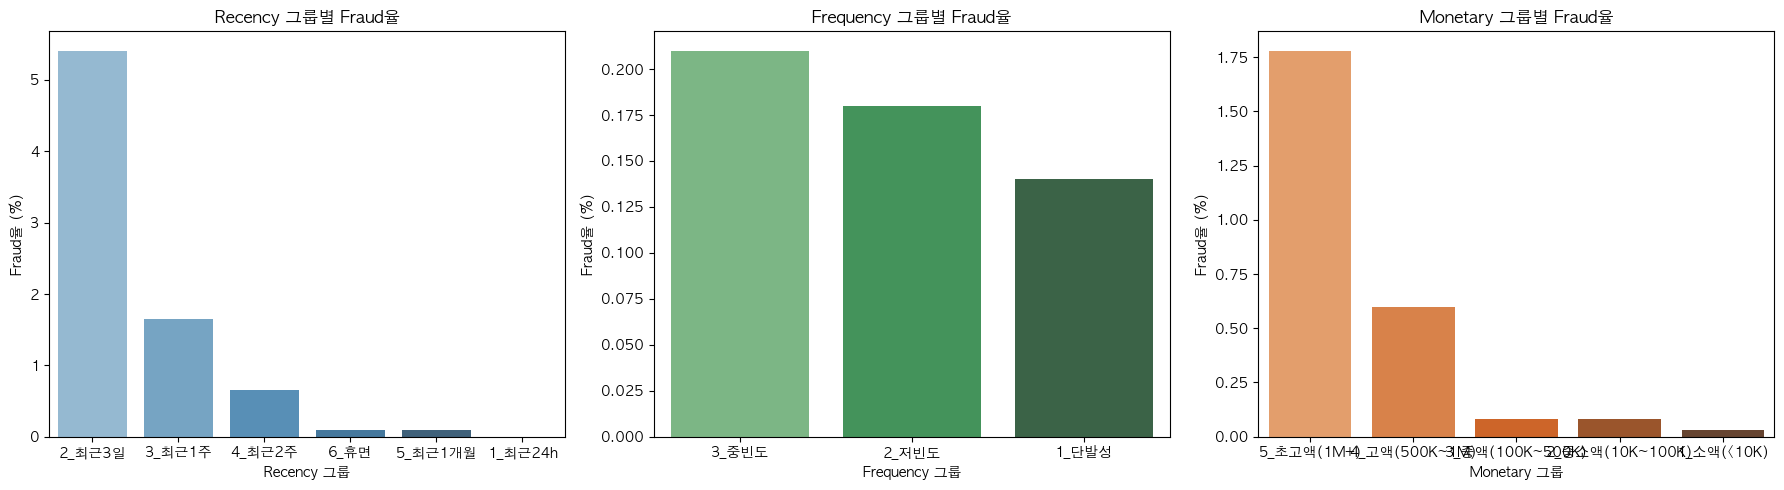

In [ ]:
# Recency / Frequency / Monetary 세그먼트별 Fraud율 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=df_recency, x="recency_group", y="fraud_rate", ax=axes[0], palette="Blues_d")
axes[0].set_title("Recency 그룹별 Fraud율")
axes[0].set_xlabel("Recency 그룹")
axes[0].set_ylabel("Fraud율 (%)")

sns.barplot(data=df_frequency, x="frequency_group", y="fraud_rate", ax=axes[1], palette="Greens_d")
axes[1].set_title("Frequency 그룹별 Fraud율")
axes[1].set_xlabel("Frequency 그룹")
axes[1].set_ylabel("Fraud율 (%)")

sns.barplot(data=df_monetary, x="monetary_group", y="fraud_rate", ax=axes[2], palette="Oranges_d")
axes[2].set_title("Monetary 그룹별 Fraud율")
axes[2].set_xlabel("Monetary 그룹")
axes[2].set_ylabel("Fraud율 (%)")

plt.tight_layout()
plt.show()

Recency: 최근 3일 이내 활동 고객에서 Fraud율이 가장 높음(5% 이상). 시간이 지날수록 Fraud율이 급격히 감소 → 신규·활성 고객군에서 사기 발생 위험이 크다는 의미.

Frequency: 거래 횟수가 중간 정도인 고객군(6~20회)에서 Fraud율이 가장 높음. 단발성 고객보다 오히려 일정 빈도를 가진 그룹이 사기에 더 노출됨.

Monetary: 거래 금액이 큰 고객일수록 Fraud율이 높아짐. 특히 100만 이상 초고액 그룹에서 Fraud율이 1.7% 이상으로 집중됨.

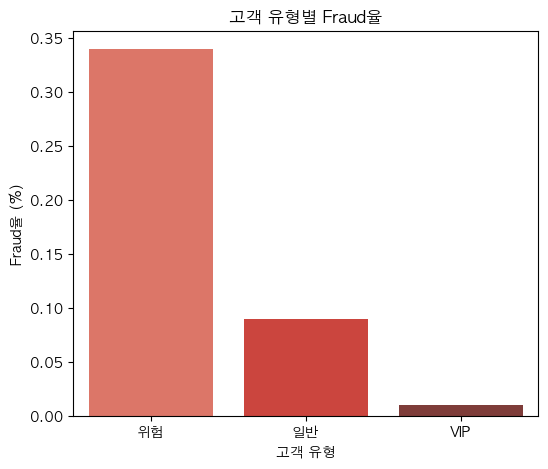

In [ ]:
# RFM 세그먼트별 Fraud 집중도 
plt.figure(figsize=(6, 5))
sns.barplot(data=df_rfm_segment, x="customer_type", y="fraud_rate", palette="Reds_d")
plt.title("고객 유형별 Fraud율")
plt.xlabel("고객 유형")
plt.ylabel("Fraud율 (%)")
plt.show()

RFM 종합 점수로 나눈 고객군에서 위험 그룹의 Fraud율이 가장 높음(0.34%).

VIP 고객은 Fraud율이 거의 없음 → 실제 충성도가 높은 고객군은 Fraud 가능성이 낮다는 점을 확인.

Fraud 대응 관점에서는 “위험 그룹”을 우선 관리해야 함.

       type  total_txn  fraud_txn  fraud_rate  fraud_amount_rate
0  TRANSFER       9562       95.0        0.99               1.43
1  CASH_OUT      40741       76.0        0.19               1.27
2   CASH_IN      25514        0.0        0.00               0.00
3   PAYMENT      38441        0.0        0.00               0.00
4     DEBIT        699        0.0        0.00               0.00


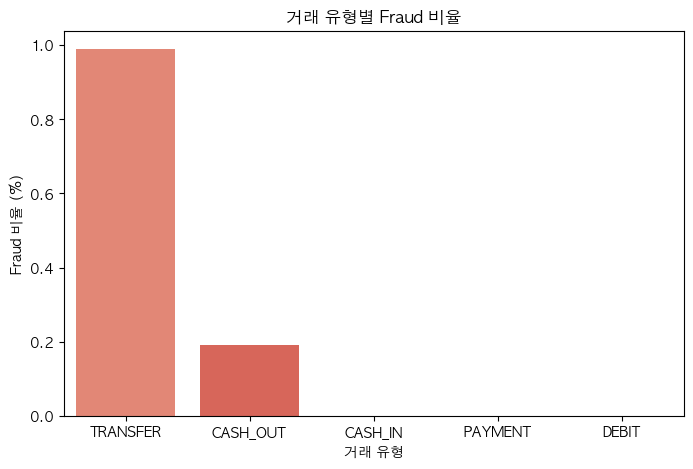

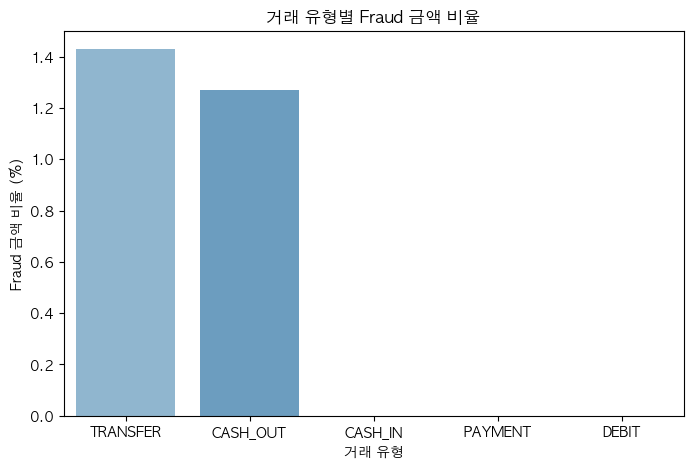

In [24]:
# 거래 유형별 Fraud 거래 비율
query_type_fraud = """
SELECT
    type,
    COUNT(*) AS total_txn,
    SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS fraud_txn,
    ROUND(100.0 * SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END)/COUNT(*), 2) AS fraud_rate,
    ROUND(100.0 * SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END)/SUM(amount), 2) AS fraud_amount_rate
FROM paysim
GROUP BY type
ORDER BY fraud_rate DESC;
"""

df_type_fraud = pd.read_sql(query_type_fraud, engine)
print(df_type_fraud)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=df_type_fraud, x="type", y="fraud_rate", palette="Reds_d")
plt.title("거래 유형별 Fraud 비율")
plt.xlabel("거래 유형")
plt.ylabel("Fraud 비율 (%)")
plt.show()

# 금액 비중도 같이 보려면
plt.figure(figsize=(8, 5))
sns.barplot(data=df_type_fraud, x="type", y="fraud_amount_rate", palette="Blues_d")
plt.title("거래 유형별 Fraud 금액 비율")
plt.xlabel("거래 유형")
plt.ylabel("Fraud 금액 비율 (%)")
plt.show()


Fraud는 **TRANSFER(이체)**와 CASH_OUT(출금) 유형에서 거의 전부 발생.

PAYMENT, CASH_IN, DEBIT 등에서는 Fraud가 거의 없음.

금융사기에서 흔히 나타나는 패턴으로, 이체 후 즉시 현금화 구조가 뚜렷하게 드러남.

금액 기준으로도 TRANSFER와 CASH_OUT이 Fraud 금액 대부분을 차지.

단순히 거래 수뿐 아니라 금액 규모 측면에서도 이 두 유형이 집중 위험군임.

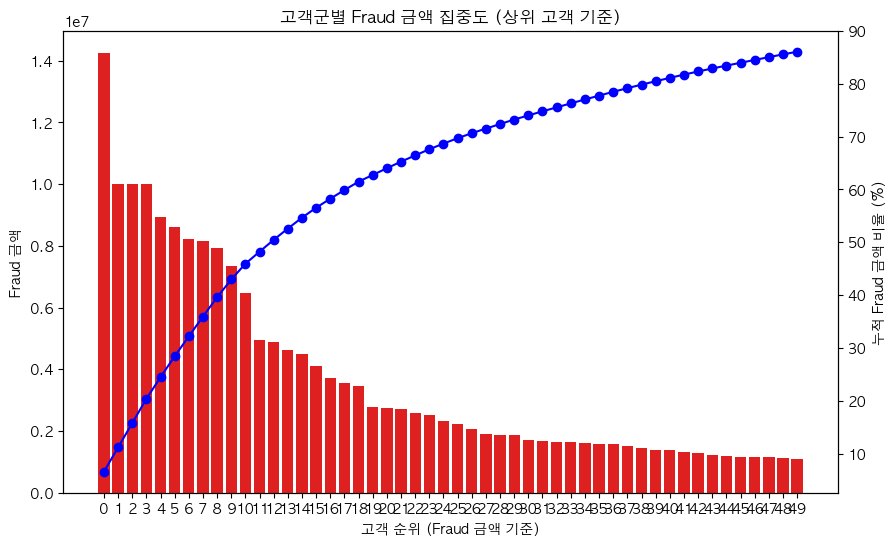

In [23]:
# RFM 세그먼트별 Fraud 금액 기여도 계산
query_rfm_contribution = """
WITH rfm_base AS (
    SELECT
        nameOrig AS customer_id,
        SUM(amount) AS monetary,
        SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END) AS fraud_amount
    FROM paysim
    GROUP BY nameOrig
)
SELECT
    customer_id,
    monetary,
    fraud_amount
FROM rfm_base
WHERE fraud_amount > 0
ORDER BY fraud_amount DESC;
"""

df_rfm_contribution = pd.read_sql(query_rfm_contribution, engine)

# 누적 기여도 계산
df_rfm_contribution["cum_fraud_amount"] = df_rfm_contribution["fraud_amount"].cumsum()
df_rfm_contribution["cum_fraud_amount_pct"] = (
    df_rfm_contribution["cum_fraud_amount"] / df_rfm_contribution["fraud_amount"].sum() * 100
)

# Pareto 차트
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_rfm_contribution.head(50),  # 상위 50 고객만 표시 (많으면 그래프 복잡해짐)
    x=df_rfm_contribution.head(50).index,
    y="fraud_amount",
    color="red"
)
plt.ylabel("Fraud 금액")
plt.xlabel("고객 순위 (Fraud 금액 기준)")
plt.title("고객군별 Fraud 금액 집중도 (상위 고객 기준)")

# 누적 기여도 라인
ax2 = plt.twinx()
ax2.plot(
    df_rfm_contribution.head(50).index,
    df_rfm_contribution.head(50)["cum_fraud_amount_pct"],
    color="blue",
    marker="o"
)
ax2.set_ylabel("누적 Fraud 금액 비율 (%)")

plt.show()


소수의 상위 고객군이 Fraud 금액의 대부분을 차지.

상위 10~20명 고객만으로 전체 Fraud 금액의 절반 이상이 발생.

Pareto 법칙 (20% 고객이 80% 위험 차지) 패턴이 보임 → 소수 고액 Fraud 고객에 대한 집중 관리 필요.